In [168]:
import torch
import torch.nn as nn
import torchvision.datasets
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

# Helper Train & Test Function

# Switch to GPU if available

In [169]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


# Load MNIST dataset

In [170]:
mnist_train_data = torchvision.datasets.MNIST(
    root="mnist_data",
    train=True,
    download=True,
    transform=ToTensor()
)

mnist_test_data = torchvision.datasets.MNIST(
    root="mnist_data",
    train=False,
    download=True,
    transform=ToTensor()
)

mnist_train_dataloader = torch.utils.data.DataLoader(mnist_train_data, batch_size=128)
mnist_test_dataloader = torch.utils.data.DataLoader(mnist_test_data, batch_size=128)

The label for this image is 5


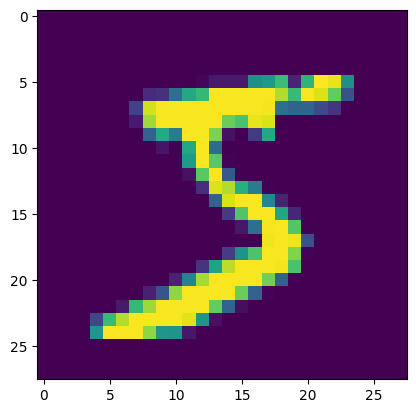

In [171]:
image, label = next(iter(mnist_train_dataloader))

plt.imshow(image[0, 0])
print(f'The label for this image is {label[0].item()}')

# Loss function

In [172]:
def loss_fn(y, label):
    batch_size = y.size(0)
    y_flat = y.view(batch_size, -1)
    
    label_flat = label.view(batch_size, -1)
    pixels_per_sample = y_flat.size(1)
    
    # Negative log-likelihood (Gaussian, variance=1)
    log_term = torch.log(torch.tensor(2 * torch.pi, device=y.device))
    negative_loss_likelihood = 0.5 * ((y_flat - 2*label_flat)**2).sum(dim=1) + 0.5 * pixels_per_sample * log_term
    negative_loss_likelihood = negative_loss_likelihood  # average over batch

    # Variance regularization
    image_var = y_flat.var(dim=1, unbiased=False)
    var_loss = ((image_var - 1)**2)

    return (negative_loss_likelihood + var_loss).mean()


# The models

In [173]:
class MNISTtoNoise(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Flatten(start_dim=1),
            
            torch.nn.Linear(784, 784),
            torch.nn.LeakyReLU(negative_slope=0.1),

            torch.nn.Linear(784, 784),
            torch.nn.LeakyReLU(negative_slope=0.1),

            torch.nn.Linear(784, 784),
            torch.nn.LeakyReLU(negative_slope=0.1),

            torch.nn.Linear(784, 784),
            torch.nn.LeakyReLU(negative_slope=0.1),
            
            torch.nn.Unflatten(1, (1, 28, 28))
        )

    def forward(self, x):
        return self.layers(x)

In [174]:
class SmallMNISTtoNoise(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Flatten(start_dim=1),
            
            torch.nn.Linear(784, 784),
            torch.nn.LeakyReLU(negative_slope=0.1),
            
            torch.nn.Unflatten(1, (1, 28, 28))
        )

    def forward(self, x):
        return self.layers(x)

In [175]:
class NoActivationMNISTtoNoise(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Flatten(start_dim=1),
            
            torch.nn.Linear(784, 784),
            torch.nn.Linear(784, 784),
            torch.nn.Linear(784, 784),
            torch.nn.Linear(784, 784),
            
            torch.nn.Unflatten(1, (1, 28, 28))
        )

    def forward(self, x):
        return self.layers(x)

# Setup for training

In [176]:
model = MNISTtoNoise().double().to(device)
small_model = SmallMNISTtoNoise().double().to(device)
no_act_model = NoActivationMNISTtoNoise().double().to(device)

# Training loop

In [ ]:
EPOCHS = 500

In [177]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

size = len(mnist_train_dataloader.dataset)
model.train()

for x in range(EPOCHS):
    for batch, (X, y) in enumerate(mnist_train_dataloader):
        X, y = X.to(device, dtype=torch.float64), (y).to(device, dtype=torch.float64)
    
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
    
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
        if batch % 100 == 0:
            loss = loss.item()
            print(f'Batch {batch}. Trained {(batch+1)*len(X)} images out of {size} total images. loss: {loss:>7f}')
torch.save(model.state_dict(), f'MNISTtoNoise.pth')

Batch 0. Trained 128 images out of 60000 total images. loss: 40705.529441
Batch 100. Trained 12928 images out of 60000 total images. loss: 4810.040587
Batch 200. Trained 25728 images out of 60000 total images. loss: 4922.230740
Batch 300. Trained 38528 images out of 60000 total images. loss: 3710.806979
Batch 400. Trained 51328 images out of 60000 total images. loss: 4081.216862


In [178]:
optimizer = torch.optim.Adam(small_model.parameters(), lr=1e-3)

size = len(mnist_train_dataloader.dataset)
small_model.train()

for x in range(EPOCHS):
    for batch, (X, y) in enumerate(mnist_train_dataloader):
        X, y = X.to(device, dtype=torch.float64), (y).to(device, dtype=torch.float64)
    
        # Compute prediction error
        pred = small_model(X)
        loss = loss_fn(pred, y)
    
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
        if batch % 100 == 0:
            loss = loss.item()
            print(f'Batch {batch}. Trained {(batch+1)*len(X)} images out of {size} total images. loss: {loss:>7f}')
torch.save(small_model.state_dict(), f'SmallMNISTtoNoise.pth')

In [179]:
optimizer = torch.optim.Adam(no_act_model.parameters(), lr=1e-3)

size = len(mnist_train_dataloader.dataset)
no_act_model.train()

for x in range(EPOCHS):
    for batch, (X, y) in enumerate(mnist_train_dataloader):
        X, y = X.to(device, dtype=torch.float64), (y).to(device, dtype=torch.float64)
    
        # Compute prediction error
        pred = no_act_model(X)
        loss = loss_fn(pred, y)
    
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
        if batch % 100 == 0:
            loss = loss.item()
            print(f'Batch {batch}. Trained {(batch+1)*len(X)} images out of {size} total images. loss: {loss:>7f}')
torch.save(no_act_model.state_dict(), f'NoActivationMNISTtoNoise.pth')

In [180]:
iterable = iter(mnist_train_dataloader)

In [181]:
class InverseLeakyReLU(nn.Module):
    def __init__(self, original_leaky_relu):
        super().__init__()
        self.alpha = original_leaky_relu.negative_slope

    def forward(self, y):
        return torch.where(
            y >= 0,
            y,
            y / self.alpha
        )

# InverseModel

Will work on all the models we've made

In [182]:
class InverseLinear(nn.Module):
    def __init__(self, original_layer):
        super().__init__()

        inverse_weights = torch.inverse(original_layer.weight.detach())
        bias = original_layer.bias.detach()
        
        self.register_buffer("inverse_weights", inverse_weights)
        self.register_buffer("bias", bias)

    def forward(self, y):
        return (y - self.bias) @ self.inverse_weights.T

In [183]:
class InverseModel(nn.Module):
    def __init__(self, original_model):
        super().__init__()

        layers = list(original_model.layers)

        inv_layers = []
        
        for layer in reversed(layers):
            if isinstance(layer, nn.Linear):
                inv_layers.append(InverseLinear(layer))

            elif isinstance(layer, nn.LeakyReLU):
                inv_layers.append(InverseLeakyReLU(layer))

            elif isinstance(layer, nn.Flatten):
                inv_layers.append(nn.Unflatten(1, (1,28,28)))

            elif isinstance(layer, nn.Unflatten):
                inv_layers.append(nn.Flatten(start_dim=1))


        self.layers = nn.Sequential(*inv_layers)

    def forward(self, x):
        return self.layers(x)

# Testing

## Forward process

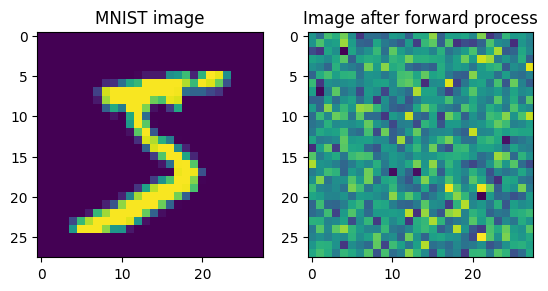

Output Mean: 8.082842485886092, Variance: 0.0005631915832721778


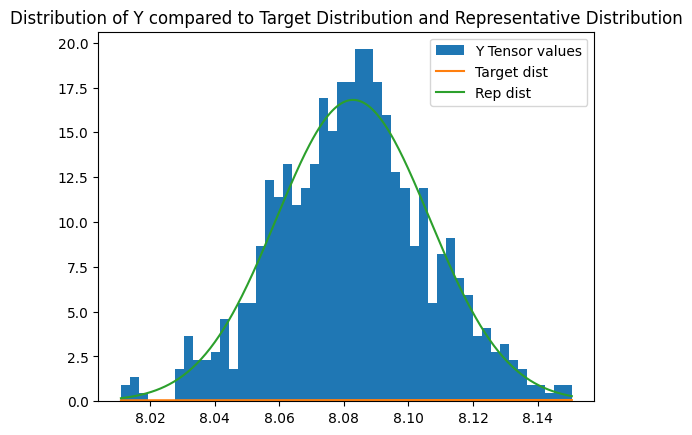

In [184]:
images, labels = next(iterable)

image = images[0,0].view(1, 28, 28).to(device=device, dtype=torch.float64)
label = labels[0]

out = model(image).detach()

fig, ax = plt.subplots(1, 2)

ax[0].imshow(image.view(28, 28).cpu())
ax[0].set_title("MNIST image")
ax[1].imshow(out.view(28, 28).cpu())
ax[1].set_title("Image after forward process")

plt.show()

print(f'Output Mean: {out.mean().item()}, Variance: {out.var().item()}')




target_dist = torch.distributions.Normal(label.item()*2, 1)
rep_dist = torch.distributions.Normal(out.mean().item(), out.var().item()**0.5)
xs = torch.linspace(out.min(), out.max(), 400)

plt.hist(out.cpu().flatten(), bins=50, density=True, label='Y Tensor values')
plt.plot(xs.numpy(), torch.exp(target_dist.log_prob(xs)).numpy(), label='Target dist')
plt.plot(xs.numpy(), torch.exp(rep_dist.log_prob(xs)).numpy(), label='Rep dist')
plt.title('Distribution of Y compared to Target Distribution and Representative Distribution')
plt.legend()
plt.show()

In [185]:
inverse_model = InverseModel(model).double()
inverse_small_model = InverseModel(small_model).double()
inverse_no_act_model = InverseModel(no_act_model).double()

y Mean: 1.3496902007107512, Variance: 0.0015359454249951798


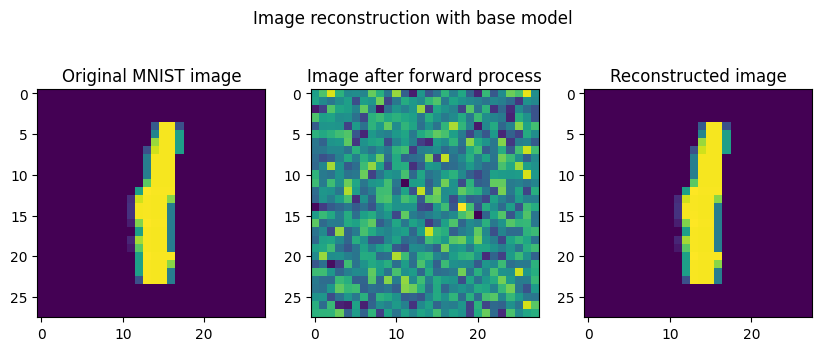

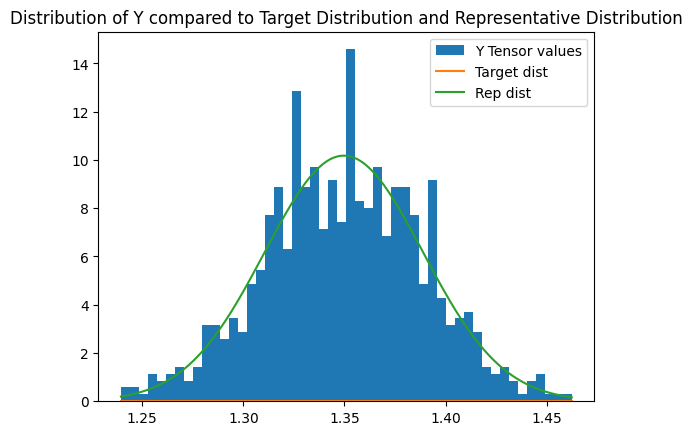

In [186]:
images, labels = next(iterable)

image = images[0,0].view(1, 28, 28).to(device=device, dtype=torch.float64)
y = model(image).detach()

reconstructed_image = inverse_model(y).detach()

fig, ax = plt.subplots(1, 3, figsize=(10, 4))

fig.suptitle('Image reconstruction with base model')

ax[0].imshow(image.view(28,28).cpu())
ax[0].set_title("Original MNIST image")

ax[1].imshow(y.view(28,28).cpu())
ax[1].set_title("Image after forward process")

ax[2].imshow(reconstructed_image.view(28,28).cpu())
ax[2].set_title("Reconstructed image")

print(f'y Mean: {y.mean().item()}, Variance: {y.var().item()}')

plt.show()

target_dist = torch.distributions.Normal(label.item()*2, 1)
rep_dist = torch.distributions.Normal(y.mean().item(), y.var().item()**0.5)
xs = torch.linspace(y.min(), y.max(), 400)

plt.hist(y.cpu().flatten(), bins=50, density=True, label='Y Tensor values')
plt.plot(xs.numpy(), torch.exp(target_dist.log_prob(xs)).numpy(), label='Target dist')
plt.plot(xs.numpy(), torch.exp(rep_dist.log_prob(xs)).numpy(), label='Rep dist')
plt.title('Distribution of Y compared to Target Distribution and Representative Distribution')
plt.legend()
plt.show()

y Mean: 0.0509510888292035, Variance: 0.009003771812407184


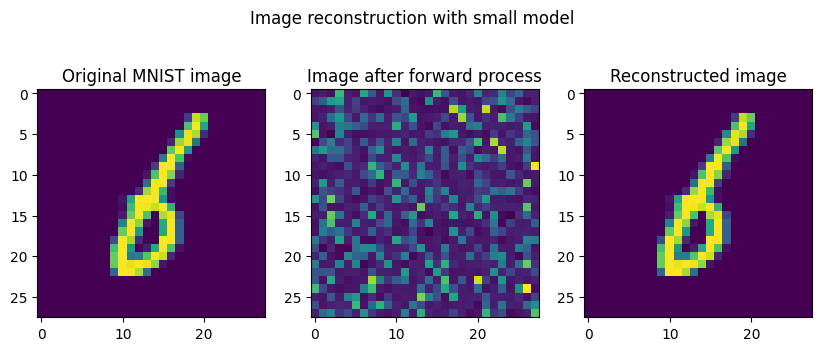

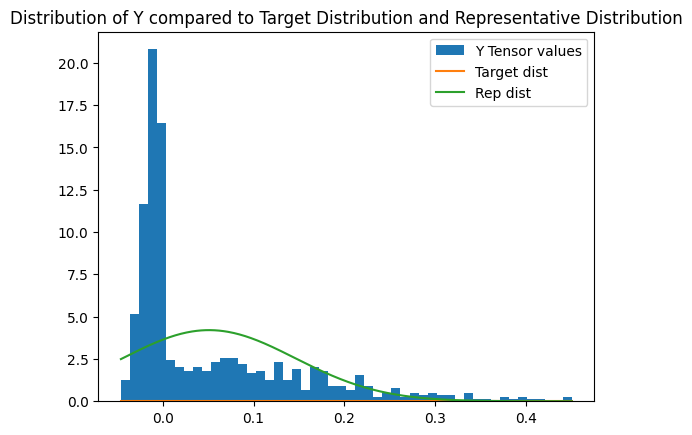

In [187]:
images, labels = next(iterable)

image = images[0,0].view(1, 28, 28).to(device=device, dtype=torch.float64)
y = small_model(image).detach()

reconstructed_image = inverse_small_model(y).detach()

fig, ax = plt.subplots(1, 3, figsize=(10, 4))

fig.suptitle('Image reconstruction with small model')

ax[0].imshow(image.view(28,28).cpu())
ax[0].set_title("Original MNIST image")

ax[1].imshow(y.view(28,28).cpu())
ax[1].set_title("Image after forward process")

ax[2].imshow(reconstructed_image.view(28,28).cpu())
ax[2].set_title("Reconstructed image")

print(f'y Mean: {y.mean().item()}, Variance: {y.var().item()}')

plt.show()

target_dist = torch.distributions.Normal(label.item()*2, 1)
rep_dist = torch.distributions.Normal(y.mean().item(), y.var().item()**0.5)
xs = torch.linspace(y.min(), y.max(), 400)

plt.hist(y.cpu().flatten(), bins=50, density=True, label='Y Tensor values')
plt.plot(xs.numpy(), torch.exp(target_dist.log_prob(xs)).numpy(), label='Target dist')
plt.plot(xs.numpy(), torch.exp(rep_dist.log_prob(xs)).numpy(), label='Rep dist')
plt.title('Distribution of Y compared to Target Distribution and Representative Distribution')
plt.legend()
plt.show()

y Mean: -0.0003351311097188777, Variance: 0.0015907313472258895


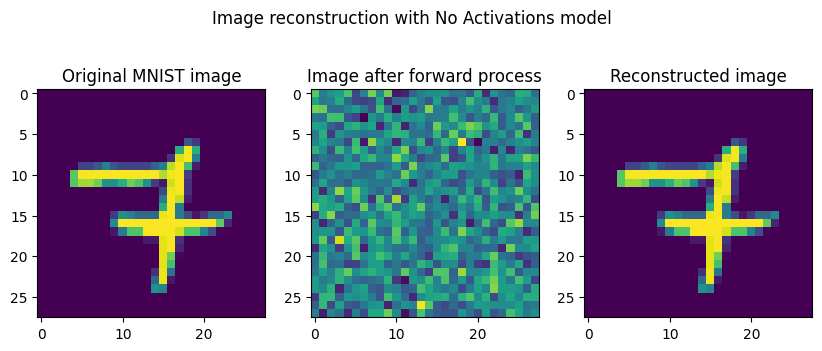

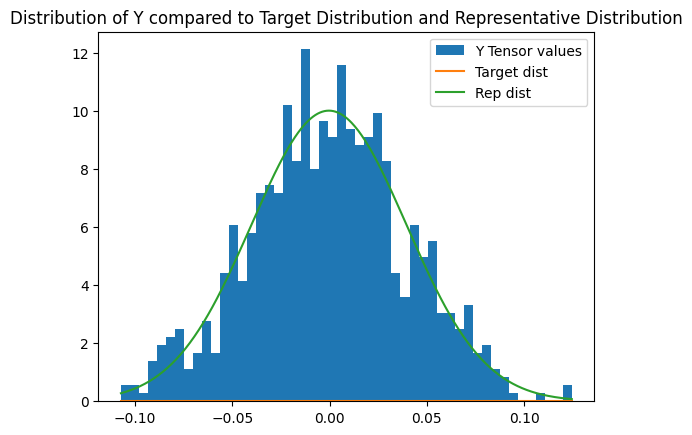

In [188]:
images, labels = next(iterable)

image = images[0,0].view(1, 28, 28).to(device=device, dtype=torch.float64)
y = no_act_model(image).detach()

reconstructed_image = inverse_no_act_model(y).detach()

fig, ax = plt.subplots(1, 3, figsize=(10, 4))

fig.suptitle('Image reconstruction with No Activations model')

ax[0].imshow(image.view(28,28).cpu())
ax[0].set_title("Original MNIST image")

ax[1].imshow(y.view(28,28).cpu())
ax[1].set_title("Image after forward process")

ax[2].imshow(reconstructed_image.view(28,28).cpu())
ax[2].set_title("Reconstructed image")

print(f'y Mean: {y.mean().item()}, Variance: {y.var().item()}')

plt.show()

target_dist = torch.distributions.Normal(label.item()*2, 1)
rep_dist = torch.distributions.Normal(y.mean().item(), y.var().item()**0.5)
xs = torch.linspace(y.min(), y.max(), 400)

plt.hist(y.cpu().flatten(), bins=50, density=True, label='Y Tensor values')
plt.plot(xs.numpy(), torch.exp(target_dist.log_prob(xs)).numpy(), label='Target dist')
plt.plot(xs.numpy(), torch.exp(rep_dist.log_prob(xs)).numpy(), label='Rep dist')
plt.title('Distribution of Y compared to Target Distribution and Representative Distribution')
plt.legend()
plt.show()

# Attempt Generation

Text(0.5, 1.0, 'Noise after inverted model')

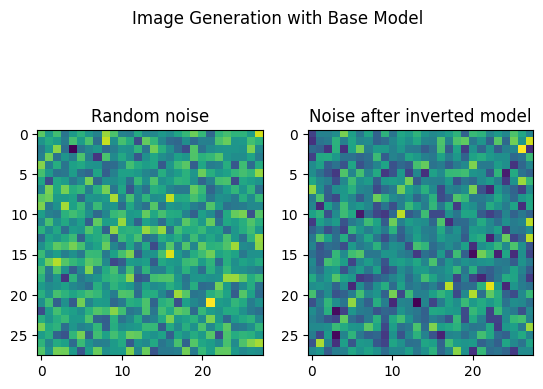

In [189]:
noise = (4*torch.randn((1, 28, 28))).to(device=device, dtype=torch.float64)
reconstructed_image = inverse_model(noise)

fig, ax = plt.subplots(1, 2)

fig.suptitle('Image Generation with Base Model')

ax[0].imshow(noise.view(28, 28).cpu())
ax[0].set_title('Random noise')

ax[1].imshow(reconstructed_image.view(28, 28).cpu())
ax[1].set_title('Noise after inverted model')

Text(0.5, 1.0, 'Noise after inverted model')

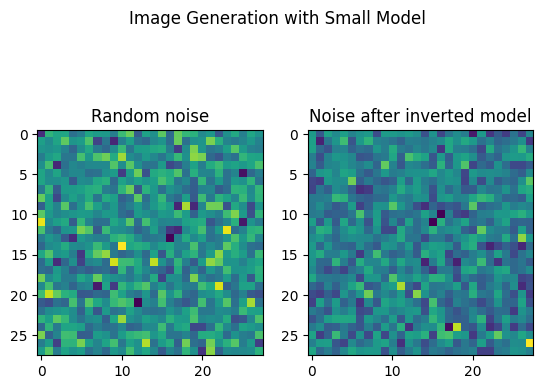

In [190]:
noise = (4*torch.randn((1, 28, 28))).to(device=device, dtype=torch.float64)
reconstructed_image = inverse_small_model(noise)

fig, ax = plt.subplots(1, 2)

fig.suptitle('Image Generation with Small Model')

ax[0].imshow(noise.view(28, 28).cpu())
ax[0].set_title('Random noise')

ax[1].imshow(reconstructed_image.view(28, 28).cpu())
ax[1].set_title('Noise after inverted model')

Text(0.5, 1.0, 'Noise after inverted model')

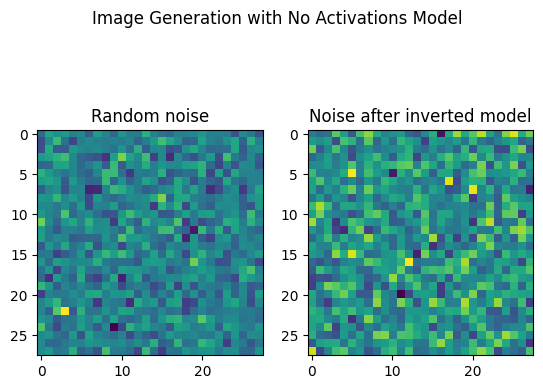

In [191]:
noise = (4*torch.randn((1, 28, 28))).to(device=device, dtype=torch.float64)
reconstructed_image = inverse_no_act_model(noise)

fig, ax = plt.subplots(1, 2)

fig.suptitle('Image Generation with No Activations Model')

ax[0].imshow(noise.view(28, 28).cpu())
ax[0].set_title('Random noise')

ax[1].imshow(reconstructed_image.view(28, 28).cpu())
ax[1].set_title('Noise after inverted model')

# Even Small pertubations cause huge errors

Text(0.5, 1.0, 'Reconstructed image')

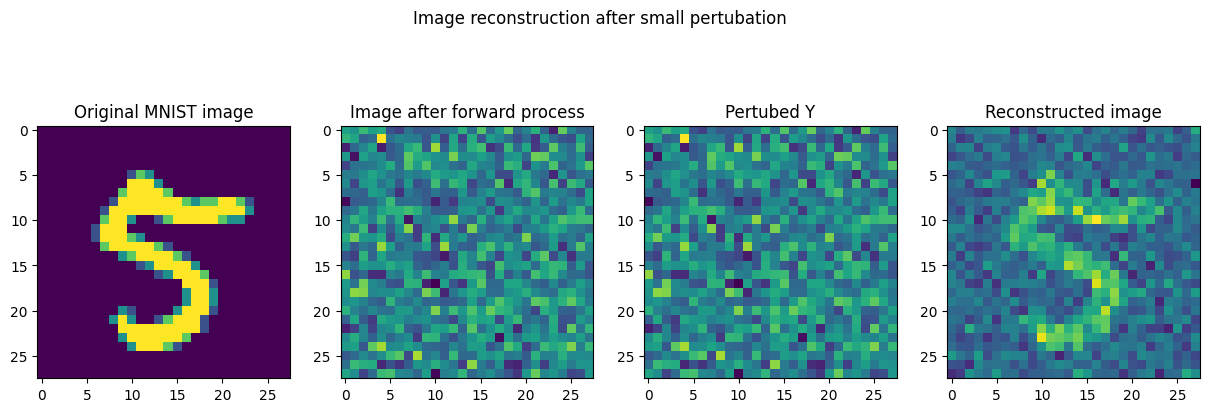

In [192]:
images, labels = next(iterable)

image = images[0,0].view(1, 28, 28).to(device=device, dtype=torch.float64)
y = model(image).detach()

pertubed_y = y + torch.randn_like(y)*0.00000000025

reconstructed_image = inverse_model(pertubed_y).detach()

fig, ax = plt.subplots(1, 4, figsize=(15, 5))

fig.suptitle('Image reconstruction after small pertubation')

ax[0].imshow(image.view(28,28).cpu())
ax[0].set_title("Original MNIST image")

ax[1].imshow(y.view(28,28).cpu())
ax[1].set_title("Image after forward process")

ax[2].imshow(pertubed_y.view(28,28).cpu())
ax[2].set_title("Pertubed Y")

ax[3].imshow(reconstructed_image.view(28,28).cpu())
ax[3].set_title("Reconstructed image")

Text(0.5, 1.0, 'Reconstructed image')

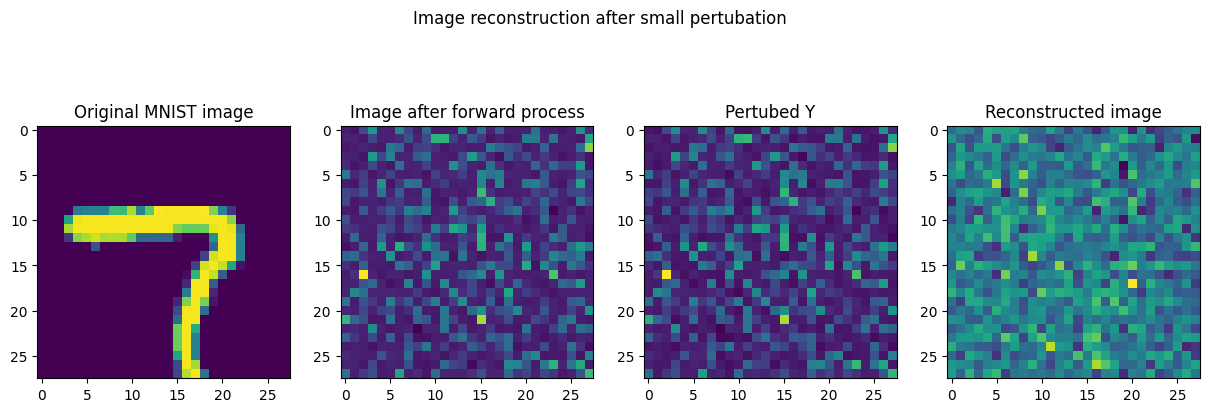

In [193]:
images, labels = next(iterable)

image = images[0,0].view(1, 28, 28).to(device=device, dtype=torch.float64)
y = small_model(image).detach()

pertubed_y = y + torch.randn_like(y)*0.01

reconstructed_image = inverse_small_model(pertubed_y).detach()

fig, ax = plt.subplots(1, 4, figsize=(15, 5))

fig.suptitle('Image reconstruction after small pertubation')

ax[0].imshow(image.view(28,28).cpu())
ax[0].set_title("Original MNIST image")

ax[1].imshow(y.view(28,28).cpu())
ax[1].set_title("Image after forward process")

ax[2].imshow(pertubed_y.view(28,28).cpu())
ax[2].set_title("Pertubed Y")

ax[3].imshow(reconstructed_image.view(28,28).cpu())
ax[3].set_title("Reconstructed image")

Text(0.5, 1.0, 'Reconstructed image')

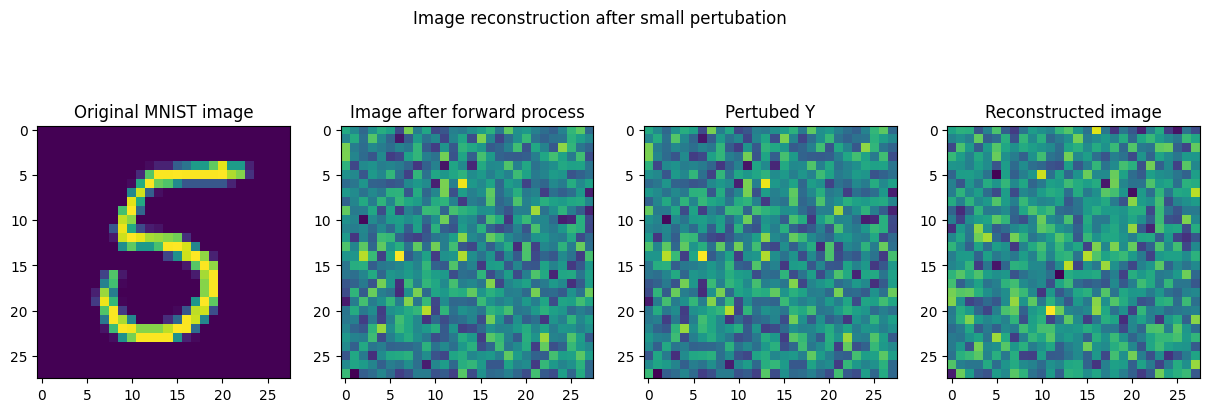

In [194]:
images, labels = next(iterable)

image = images[0,0].view(1, 28, 28).to(device=device, dtype=torch.float64)
y = no_act_model(image).detach()

pertubed_y = y + torch.randn_like(y)*0.00000001

reconstructed_image = inverse_no_act_model(pertubed_y).detach()

fig, ax = plt.subplots(1, 4, figsize=(15, 5))

fig.suptitle('Image reconstruction after small pertubation')

ax[0].imshow(image.view(28,28).cpu())
ax[0].set_title("Original MNIST image")

ax[1].imshow(y.view(28,28).cpu())
ax[1].set_title("Image after forward process")

ax[2].imshow(pertubed_y.view(28,28).cpu())
ax[2].set_title("Pertubed Y")

ax[3].imshow(reconstructed_image.view(28,28).cpu())
ax[3].set_title("Reconstructed image")